In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import copy
from nltk.corpus import stopwords 

In [2]:
#PATH = '../finanz_vs_news'
PATH = r'..\HackathonDaten\Nachrichten und Kurse\\'
#PATH = ''

In [3]:
#############################################################
#### example how to read the daily stock rates with PATH ####
companyLabel = 'A'    # label of company to load / last column
df_stock = pd.read_csv(PATH+'StocksDaily\ALL_2007-01-01_2017-10-16.csv', parse_dates=["Date"])
StockTickers = df_stock['ticker'].unique()
df_stock = df_stock[df_stock['ticker']=='A']
# save data to pickle
df_stock.to_pickle(PATH+'StocksDaily\stock_'+companyLabel+'.pickle')

In [4]:
# read in data
df_stock = pd.read_pickle(PATH+'StocksDaily\stock_'+companyLabel+'.pickle')

In [5]:
#####################################
#### dictionary for stock labels ####
# get the ticker from our data
df_dummy = pd.read_csv(PATH+'StocksDaily\ALL_2007-01-01_2017-10-16.csv', parse_dates=["Date"])
StockTickers = df_dummy['ticker'].unique()   # get the unique tickers once
# read in dic with all tickers worldwide
TickerAll = pd.read_csv('Yahoo Ticker Symbols - September 2017.csv', delimiter=';')
# delete unneeded columns
del TickerAll['Country']
del TickerAll['Exchange']
# select onyl the ticker of the companies we have
TickerDic = TickerAll.loc[TickerAll['Ticker'].isin(StockTickers)]

namescat = copy.deepcopy(TickerDic['Name'].str.cat(sep = ' '))
namescat = namescat.replace(',' , ' ')
namescat = namescat.replace('.' , ' ')
namescat = namescat.split(' ')
namescat = pd.Series(namescat)
toDel = namescat.value_counts()[:24]
toDel = toDel.index.tolist()

del toDel[7]
del toDel[toDel == ' ']
# take longes ones first, otherwise in replace string one might only replace parts, leaving a rest
toDel.sort(key = lambda x: len(x), reverse=True)

shortName = copy.deepcopy(TickerDic['Name'].values)

for jj, dummy in enumerate(shortName):
    for ii in toDel:
        dummy = dummy.replace(',','')
        dummy = dummy.replace('.','')
        dummy = dummy.replace(' ' + ii,'')
        shortName[jj] = dummy
        
TickerDic['RedName'] = shortName
# save dictionary
TickerDic.to_pickle('TickerDic.pickle')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
shortName = copy.deepcopy(TickerDic['Name'].values)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english'))
word_tokens = word_tokenize(shortName[0])
word_tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tobia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['Aflac', 'Incorporated']

In [814]:
shortName

array(['Aflac Incorporated', 'Assurant, Inc.', 'Unum Group',
       'The Interpublic Group of Companies, Inc.', 'Omnicom Group Inc.',
       'Northrop Grumman Corporation', 'Textron Inc.',
       'The Boeing Company', 'General Dynamics Corporation',
       'L3 Technologies, Inc.', 'Lockheed Martin Corporation',
       'Raytheon Company', 'United Technologies Corporation',
       'CF Industries Holdings, Inc.', 'Monsanto Company',
       'C.H. Robinson Worldwide, Inc.',
       'Expeditors International of Washington, Inc.',
       'FedEx Corporation', 'United Parcel Service, Inc.',
       'Abercrombie & Fitch Co.', 'Nordstrom, Inc.', 'L Brands, Inc.',
       'Ross Stores, Inc.', 'Urban Outfitters, Inc.',
       'Salesforce.com, inc.', 'Intuit Inc.', 'Oracle Corporation',
       'Red Hat, Inc.', 'Affiliated Managers Group, Inc.',
       'Franklin Resources, Inc.',
       'The Bank of New York Mellon Corporation', 'BlackRock, Inc.',
       'Federated Investors, Inc.', 'Invesco Ltd.', 'Leg

In [726]:
# load dictionary
TickerDic = pd.read_pickle('TickerDic.pickle')

In [771]:
#########################################
### LoughranMcDonald MasterDictionary ###
MasterDic = pd.read_csv('LoughranMcDonald_MasterDictionary_2016.csv', delimiter=';')

# get positive words
PosDic = MasterDic[MasterDic['Positive'] !=0]
PosDic = PosDic.sort_values(by=['Word Count'], ascending=False)
PostDic = PosDic['Word']
# save dictionary
PostDic.to_pickle('DicPositiveWords.pickle')

# get negative words
NegDic = MasterDic[MasterDic['Negative'] !=0]
NegDic = NegDic.sort_values(by=['Word Count'], ascending=False)
NegDic = NegDic['Word']
# save dictionary
NegDic.to_pickle('DicNegativeWords.pickle') 

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


85081               LOSS
85005             LOSSES
84942        TERMINATION
84917            AGAINST
84829            DEFAULT
84795            CLOSING
84786         IMPAIRMENT
84775            ADVERSE
84704          ADVERSELY
84627            FAILURE
84585         LITIGATION
84582          DISCLOSED
84505         LIMITATION
84479           RESTATED
84377            DAMAGES
84373         TERMINATED
84349      RESTRUCTURING
84348          TERMINATE
84328             BREACH
84321             UNABLE
84319            DECLINE
84307         BANKRUPTCY
84246              FORCE
84236             CLAIMS
84174        LIMITATIONS
84148             UNPAID
84126       DISCONTINUED
84105        LIQUIDATION
84052              FRAUD
84009           CRITICAL
              ...       
32922        DISAPPOINTS
33087        MISLABELLED
33165       QUESTIONABLY
32724       SUSPICIOUSLY
32240         ABRUPTNESS
32098          RIDICULED
31754         DENIGRATED
31631        ABUSIVENESS
31428       RETALIATIONS


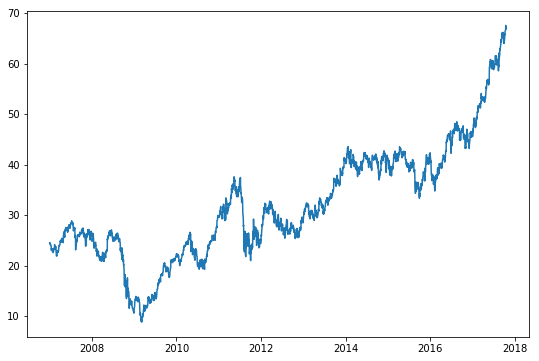

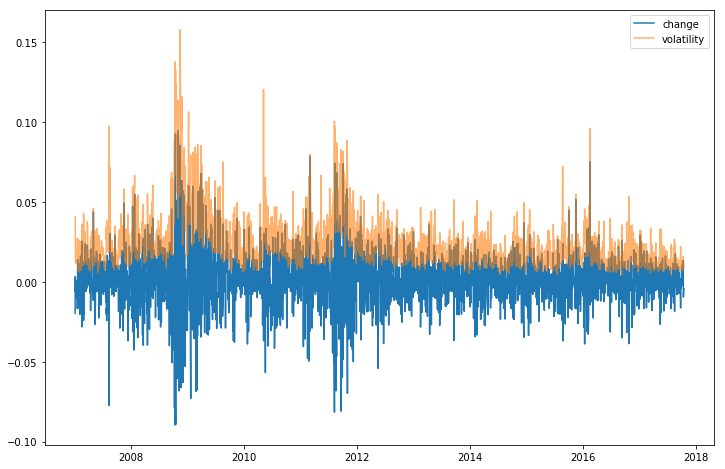

In [799]:
#########################
datX = df_stock['Date']
datZ = df_stock['Close']
fig = plt.figure(figsize=(9,6))   # create a figure with specified size
ax1 = fig.add_subplot(111)        
ax1.set_xlabel('')                                  # set x label
ax1.set_ylabel('')                                  # set y label
ax1.plot(datX,datZ)                                 # plot

relChange = (df_stock['Close']-df_stock['Open']) / df_stock['Open']
relVolatility = (df_stock['High']-df_stock['Low'])/df_stock['Open'] 

fig = plt.figure(figsize=(12,8))   # create a figure with specified size
ax1 = fig.add_subplot(111)
ax1.plot(datX, relChange, alpha=1, label='change')
ax1.plot(datX, relVolatility, alpha=.6, label='volatility')
ax1.legend()

In [792]:
df_stock

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2007-01-03,25.028612,25.379112,24.356224,24.535049,23.154404,3599200.0,A
1,2007-01-04,24.535049,24.749641,23.934191,24.613733,23.228655,2899000.0,A
2,2007-01-05,24.535049,24.606581,24.320457,24.384836,23.012638,3741800.0,A
3,2007-01-08,24.306152,24.377682,24.091558,24.298998,22.931633,2176900.0,A
4,2007-01-09,24.377682,24.549356,24.055794,24.327610,22.958633,1937900.0,A
5,2007-01-10,24.349070,24.349070,23.869814,24.105865,22.749365,3016000.0,A
6,2007-01-11,24.198856,24.349070,23.855509,24.105865,22.749365,2919400.0,A
7,2007-01-12,24.084406,24.349070,23.991417,24.034334,22.681862,1965400.0,A
8,2007-01-16,23.969957,24.270386,23.848354,23.991417,22.641356,4328900.0,A
9,2007-01-17,23.912733,23.948498,23.433475,23.512159,22.189075,3723000.0,A
